In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.8 MB/s eta 0:00:00


In [ ]:
!pip3 install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 45.1 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376422 sha256=696d48801490dfdf70f5de70191ab6799392a1d99308b56d7c60243cc31bf536
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt

In [ ]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPO, self).__init__()
        self.data = []

        # 네트워크 구조
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc_mu = nn.Linear(256, action_dim)
        self.fc_std = nn.Linear(256, action_dim)
        self.fc_v = nn.Linear(256, 1)

        # 옵티마이저
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = torch.exp(self.fc_std(x))  # 표준편차는 항상 양수
        return mu, std

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append(prob_a)
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s = torch.tensor(s_lst, dtype=torch.float)
        a = torch.tensor(a_lst, dtype=torch.float)
        r = torch.tensor(r_lst, dtype=torch.float)
        s_prime = torch.tensor(s_prime_lst, dtype=torch.float)
        prob_a = torch.tensor(prob_a_lst, dtype=torch.float)
        done_mask = torch.tensor(done_lst, dtype=torch.float)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            mu, std = self.pi(s)
            dist = torch.distributions.Normal(mu, std)
            log_prob = dist.log_prob(a).sum(dim=1, keepdim=True)

            ratio = torch.exp(log_prob - prob_a)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s), td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()


In [ ]:
def main():
    env = gym.make('BipedalWalker-v3')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    model = PPO(state_dim, action_dim)
    model.load_state_dict(torch.load("/content/drive/MyDrive/RL/ppo_bipedal_.pth"))

    score = 0.0
    avg_scores = []
    print_interval = 10
    best_score = -float('inf')

    for n_epi in range(1000):
        s, _ = env.reset()
        done = False
        while not done:
            mu, std = model.pi(torch.from_numpy(s).float())
            dist = torch.distributions.Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a).sum(dim=0, keepdim=True)
            s_prime, r, done, truncated, _ = env.step(a.numpy())
            model.put_data((s, a.numpy(), r / 10.0, s_prime, log_prob.detach().numpy(), done))
            s = s_prime
            score += r

            if len(model.data) >= T_horizon:
                model.train_net()
            if done or truncated:
              break


        if score >= best_score:
            best_score = score
            torch.save(model.state_dict(), f"ppo_bipedal{n_epi}_.pth")
            print(f"New best score: {best_score}. Model saved.")

        if n_epi%print_interval==0 and n_epi!=0:
            avg_score = score
            avg_scores.append(avg_score)  # 평균 점수 저장
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score))

        score = 0.0


    env.close()
    plt.plot(avg_scores)
    plt.xlabel('Episodes (x20)')
    plt.ylabel('Average Score')
    plt.title('Average Score vs Episodes')
    plt.show()

In [ ]:
#Hyperparameters
learning_rate = 0.0003
gamma         = 0.99
lmbda         = 0.95
eps_clip      = 0.2
K_epoch       = 3
T_horizon     = 2048

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


New best score: -105.84951988818973. Model saved.
New best score: -92.48681282991721. Model saved.
# of episode :10, avg score : -120.5
New best score: -85.63530160191571. Model saved.
New best score: -84.66560875986343. Model saved.
New best score: -81.96342169926325. Model saved.
# of episode :20, avg score : -82.0
New best score: -79.96542510548542. Model saved.
# of episode :30, avg score : -111.3
# of episode :40, avg score : -116.4
New best score: -68.93033092217904. Model saved.
# of episode :50, avg score : -106.1
# of episode :60, avg score : -80.0
# of episode :70, avg score : -111.8
# of episode :80, avg score : -87.7
# of episode :90, avg score : -82.5
# of episode :100, avg score : -75.7
New best score: -65.52863369630458. Model saved.
# of episode :110, avg score : -73.8
# of episode :120, avg score : -84.1
# of episode :130, avg score : -110.3
# of episode :140, avg score : -103.5
# of episode :150, avg score : -182.9
# of episode :160, avg score : -138.0
# of episode :1

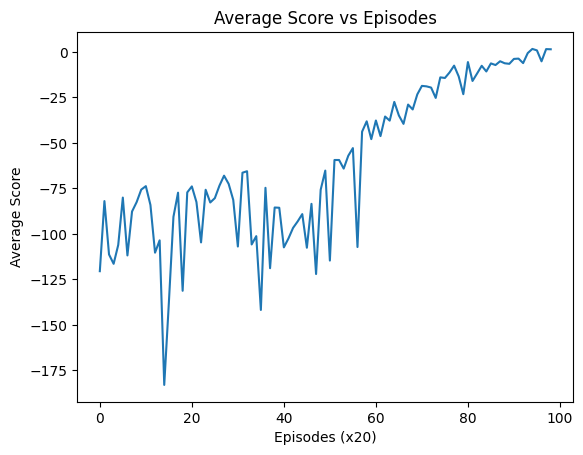

In [ ]:
main()

<ipython-input-20-e160e97bde47>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/RL/ppo_bipedal_.pth"))


New best score: 210.7255124721576. Model saved.
New best score: 216.96374795302322. Model saved.
New best score: 227.28952632480056. Model saved.
# of episode :10, avg score : 210.9
New best score: 245.91822775885302. Model saved.
# of episode :20, avg score : -92.0
# of episode :30, avg score : 225.6
# of episode :40, avg score : 240.7
# of episode :50, avg score : 226.5
# of episode :60, avg score : 216.2
# of episode :70, avg score : -95.5
New best score: 246.28580208741042. Model saved.
# of episode :80, avg score : 211.9
New best score: 246.43813704756457. Model saved.
# of episode :90, avg score : 246.4
New best score: 248.3905046765069. Model saved.
New best score: 248.80137919203665. Model saved.
# of episode :100, avg score : 248.8
New best score: 251.56922449032214. Model saved.
New best score: 265.6264983019368. Model saved.
# of episode :110, avg score : 248.6
# of episode :120, avg score : 237.0
# of episode :130, avg score : 232.0
# of episode :140, avg score : 246.5
# of

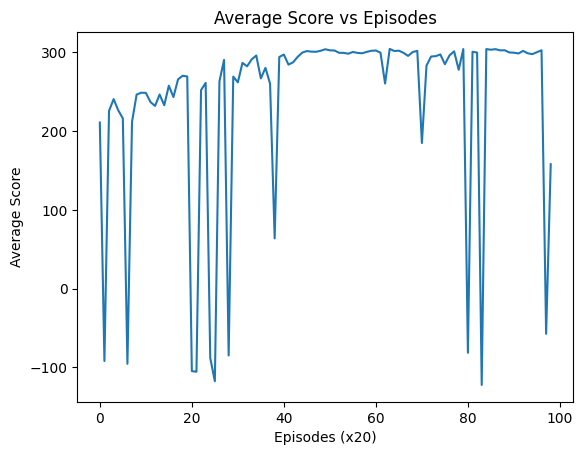

In [ ]:
main()